In [381]:
import math
import os
import sys
import pandas as pd
sys.path.append("/home/weber/PycharmProjects/EXOTIC/src")
from statannot import add_stat_annotation

pd.options.mode.chained_assignment = None  # default='warn'
import multiprocessing
import numpy as np
import collections
from tqdm import tqdm

import parmap

# tqdm.pandas()
from pprint import pprint
from scipy.stats import zscore
from scipy import stats

import requests
import re
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors as mc
from matplotlib.colors import LogNorm
import json
import matplotlib.ticker as mtick
from utils.utils import load_config_file

## YAML FILES CONFIG
yaml = load_config_file(config_file="/home/weber/PycharmProjects/EXOTIC/src/config.yaml")
exotic_files = yaml
files = yaml

import matplotlib.font_manager as font_manager

font_dirs = ['/home/weber/Fonts', ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['font.weight'] = 'light'

/home/weber/.conda/envs/hail/lib/python3.6/site-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.


# Hail & heavy stuff


In [1]:
import hail as hl
hl.init(min_block_size=256)
import os
import pandas as pd
import subprocess
os.environ['PYSPARK_SUBMIT_ARGS'] = "--driver-memory 700G pyspark-shell"
# !module load java/java-1.8
gs = "/gstock/biolo_datasets/variation/gnomAD/r2.1.1/vcf/exomes/gnomad.exomes.r2.1.1.sites.ht/"
# gs = "/data/scratch/gnomAD/v3/gnomad.genomes.v3.1.sites.ht/"
data = hl.read_table(gs)
data

Running on Apache Spark version 2.4.1
SparkUI available at http://vega.local:4040
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.64-1ef70187dc78
LOGGING: writing to /enadisk/maison/sage2016/weber/PycharmProjects/EXOTIC/notebooks/Hail/hail-20210423-0840-0.2.64-1ef70187dc78.log


In [2]:
exotic = pd.read_parquet("/gstock/EXOTIC/data/EXOTIC/EXOTIC_modified_zscore_mean_prop_corrected_with_variable.parquet")
biomart = pd.read_csv('/gstock/EXOTIC/data/OTHERS/biomart_refseq_ensembl_hgnc.txt.gz', compression='gzip', sep='\t')
exotic = pd.merge(biomart[['Gene name', 'Chromosome/scaffold name']].drop_duplicates().rename({'Gene name' : 'Gene', 'Chromosome/scaffold name' : 'CHROM'}, axis=1), exotic, on=['Gene'])
exotic['CHROM'] = exotic['CHROM'].astype(str)

exotic = exotic.loc[~exotic['CHROM'].str.contains('HSCHR|HG')]
exotic = exotic[['CHROM', 'CDS_start', 'CDS_stop', 'MAP']].sort_values(by=['CHROM', 'CDS_start'])
exotic.to_csv('/biolo/ngs/remap/EXOTIC.bed', header=False, sep='\t', index=False)

/home/weber/.conda/envs/hail/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
bed_file = hl.import_bed('/biolo/ngs/remap/EXOTIC.bed', reference_genome='GRCh37')
bed_file.count()
# bed_file = bed_file.head(100)
# bed_file.show()

2021-04-23 08:40:38 Hail: INFO: Reading table without type imputation
  Loading field 'f0' as type str (user-supplied)
  Loading field 'f1' as type int32 (user-supplied)
  Loading field 'f2' as type int32 (user-supplied)
  Loading field 'f3' as type str (user-supplied)


29309

In [11]:
data_lite = data.filter(hl.is_defined(bed_file[data.locus]))
data_lite = data_lite.filter(data_lite.variant_type == 'snv')
data_lite = data_lite.filter(data_lite.freq[0]['AC'] > 0)
# data_lite['AF'] = data_lite.freq[0]['AC']
data_lite = data_lite.annotate(
    MAP = bed_file[data_lite.locus].target,
    AF = data_lite.freq[0]['AF'],
    id = hl.str(data_lite.vep.id).replace('/', '_')
)
data_lite = data_lite.select(data_lite.AF, data_lite.rsid, data_lite.variant_type, data_lite.vep.end, data_lite.id, data_lite.vep.most_severe_consequence, data_lite.MAP)

# data_lite = data_lite.key_by('id')

In [ ]:
data_lite.describe()

In [8]:
data_lite.head(10).show()

2021-04-23 08:44:03 Hail: INFO: Ordering unsorted dataset with network shuffle
2021-04-23 08:44:03 Hail: INFO: Ordering unsorted dataset with network shuffle


+---------------+------------+----------+---------------+--------------+--------+----------------+-------------------------+
| locus         | alleles    |       AF | rsid          | variant_type |    end | id             | most_severe_consequence |
+---------------+------------+----------+---------------+--------------+--------+----------------+-------------------------+
| locus<GRCh37> | array<str> |  float64 | str           | str          |  int32 | str            | str                     |
+---------------+------------+----------+---------------+--------------+--------+----------------+-------------------------+
| 1:906494      | ["G","A"]  | 3.30e-05 | "rs200703251" | "snv"        | 906494 | "1_906494_G_A" | "missense_variant"      |
| 1:906496      | ["C","T"]  | 1.41e-05 | "rs547187116" | "snv"        | 906496 | "1_906496_C_T" | "missense_variant"      |
| 1:906497      | ["G","A"]  | 7.46e-05 | "rs200313046" | "snv"        | 906497 | "1_906497_G_A" | "missense_variant"      |
| 1:906503      | ["C","A"]  | 1.37e-05 | "rs748042832" | "snv"        | 906503 | "1_906503_C_A" | "missense_variant"      |
| 1:906505      | ["C","T"]  | 2.30e-05 | "rs368512764" | "snv"        | 906505 | "1_906505_C_T" | "missense_variant"      |
| 1:906506      | ["G","A"]  | 5.96e-05 | "rs777113439" | "snv"        | 906506 | "1_906506_G_A" | "missense_variant"      |
| 1:906507      | ["G","A"]  | 1.74e-04 | "rs371554805" | "snv"        | 906507 | "1_906507_G_A" | "synonymous_variant"    |
| 1:906511      | ["C","T"]  | 5.94e-05 | "rs770507483" | "snv"        | 906511 | "1_906511_C_T" | "missense_variant"      |
| 1:906515      | ["C","T"]  | 3.63e-05 | "rs375803737" | "snv"        | 906515 | "1_906515_C_T" | "missense_variant"      |
| 1:906518      | ["C","T"]  | 4.56e-06 | "rs199724483" | "snv"        | 906518 | "1_906518_C_T" | "missense_variant"      |
+---------------+------------+----------+---------------+--------------+--------+----------------+-------------------------+

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| transcript_consequences                                                                                                                                                                                       |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| array<struct{allele_num: int32, amino_acids: str, biotype: str, canonical: int32, ccds: str, cdna_start: int32, cdna_end: int32, cds_end: int32, cds_start: int32, codons: str, consequence_terms: array<s... |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| [(1,NA,"protein_coding",NA,NA,NA,NA,NA,NA,NA,["downstream_gene_variant"],4090,NA,NA,"ENSG00000187642",NA,"C1orf170","HGNC","28208",NA,NA,NA,"MODIFIER",NA,NA,NA,NA,NA,1,NA,NA,NA,NA,"ENSP00000343864",NA,N... |
| [(1,NA,"protein_coding",NA,NA,NA,NA,NA,NA,NA,["downstream_gene_variant"],4088,NA,NA,"ENSG00000187642",NA,"C1orf170","HGNC","28208",NA,NA,NA,"MODIFIER",NA,NA,NA,NA,NA,1,NA,NA,NA,NA,"ENSP00000343864",NA,N... |
| [(1,NA,"protein_coding",NA,NA,NA,NA,NA,NA,NA,["downstream_gene_variant"],4087,NA,NA,"ENSG00000187642",NA,"C1orf170","HGNC","28208",NA,NA,NA,"MODIFIER",NA,NA,NA,NA,NA,1,NA,NA,NA,NA,"ENSP00000343864",NA,N... |
| [(1,NA,"protein_coding",NA,NA,NA,NA,NA,NA,NA,["downstream_gene_variant"],4081,NA,NA,"ENSG00000187642",NA,"C1orf170","HGNC","28208",NA,NA,NA,"MODIFIER",NA,NA,NA,NA,NA,1,NA,NA,NA,NA,"ENSP00000343864",NA,N... |
| [(1,NA,"protein_coding",NA,NA,NA,NA,NA,NA,NA,["downstream_gene_variant"],4079,NA,NA,"ENSG00000187642",NA,"C

In [5]:
data_lite.count()

2021-04-23 08:41:11 Hail: INFO: Ordering unsorted dataset with network shuffle


700207

In [12]:
data_lite.export('/gstock/EXOTIC/data/VARIATIONS/EXOTIC_variations_gnomad_lite.tsv.bgz')

2021-04-23 08:46:47 Hail: INFO: Ordering unsorted dataset with network shuffle
2021-04-23 08:46:47 Hail: INFO: Ordering unsorted dataset with network shuffle
2021-04-23 08:47:26 Hail: INFO: merging 9997 files totalling 15.5M...
2021-04-23 08:47:27 Hail: INFO: while writing:
    /gstock/EXOTIC/data/VARIATIONS/EXOTIC_variations_gnomad_lite.tsv.bgz
  merge time: 1.723s


In [7]:
cadd_hail = hl.import_table('/gstock/biolo_datasets/variation/CADD/1.6/gnomad.genomes.r2.1.1.h.snv.tsv.gz', force_bgz=True)
cadd_hail = cadd_hail.annotate(
    id = cadd_hail['#Chrom'] + '_' + cadd_hail['Pos'] + '_' + cadd_hail['Ref'] + '_' + cadd_hail['Alt']
)
cadd_hail = cadd_hail.key_by('id')

2021-04-22 19:21:09 Hail: INFO: Reading table without type imputation
  Loading field '#Chrom' as type str (not specified)
  Loading field 'Pos' as type str (not specified)
  Loading field 'Ref' as type str (not specified)
  Loading field 'Alt' as type str (not specified)
  Loading field 'RawScore' as type str (not specified)
  Loading field 'PHRED' as type str (not specified)


In [10]:
t = data_lite.annotate(
    PHRED = cadd_hail[data_lite.id].PHRED
)

2021-04-22 19:22:21 Hail: INFO: Ordering unsorted dataset with network shuffle


In [ ]:
t.export('/gstock/EXOTIC/data/VARIATIONS/EXOTIC_variations_cadd.tsv.bgz')

2021-04-22 19:23:06 Hail: INFO: Ordering unsorted dataset with network shuffle
2021-04-22 19:23:07 Hail: INFO: Ordering unsorted dataset with network shuffle
2021-04-22 19:23:57 Hail: INFO: Ordering unsorted dataset with network shuffle
2021-04-22 19:27:24 Hail: INFO: Ordering unsorted dataset with network shuffle


In [1]:
import vaex
vaex_exotic_gnomad = vaex.from_csv('/gstock/EXOTIC/data/VARIATIONS/EXOTIC_variations_gnomad_lite.tsv.bgz', compression='gzip', delimiter='\t')
# vaex_exotic_gnomad


In [3]:
import pandas as pd
pandas_exotic_gnomad = pd.read_csv('/gstock/EXOTIC/data/VARIATIONS/EXOTIC_variations_gnomad_lite.tsv.bgz', compression='gzip', sep='\t')
pandas_exotic_gnomad


,locus,alleles,AF,rsid,variant_type,end,id,most_severe_consequence,MAP
0,1:906494,"[""G"",""A""]",0.000033,rs200703251,snv,906494,1_906494_G_A,missense_variant,PLEKHN1_906493-906588
1,1:906496,"[""C"",""T""]",0.000014,rs547187116,snv,906496,1_906496_C_T,missense_variant,PLEKHN1_906493-906588
2,1:906497,"[""G"",""A""]",0.000075,rs200313046,snv,906497,1_906497_G_A,missense_variant,PLEKHN1_906493-906588
3,1:906503,"[""C"",""A""]",0.000014,rs748042832,snv,906503,1_906503_C_A,missense_variant,PLEKHN1_906493-906588
4,1:906505,"[""C"",""T""]",0.000023,rs368512764,snv,906505,1_906505_C_T,missense_variant,PLEKHN1_906493-906588
...,...,...,...,...,...,...,...,...,...
700202,Y:21903299,"[""A"",""G""]",0.000015,rs776861979,snv,21903299,Y_21903299_A_G,missense_variant,KDM5D_21903204-21903374
700203,Y:21903328,"[""C"",""T""]",0.000030,rs1454244319,snv,21903328,Y_21903328_C_T,missense_variant,KDM5D_21903204-21903374
700204,Y:21903334,"[""T"",""C""]",0.000030,rs1378103890,snv,21903334,Y_21903334_T_C,missense_variant,KDM5D_21903204-21903374
700205,Y:21903374,"[""T"",""A""]",0.000018,rs762596355,snv,21903374,Y_21903374_T_A,missense_variant,KDM5D_21903204-21903374


In [6]:
import tabix

url = "/gstock/biolo_datasets/variation/benchmark/MISTIC/PRECOMPUTING_CADD/2021/MISTIC_GRCh37_website_2021.tsv.bgz"
tb = tabix.open(url)
chrom = '1'
pos = 906494
try:
    records = tb.query("{}".format(chrom), int(pos)-1, int(pos))
    print([r for r in records])
except:
    pass

[['1', '906494', 'G', 'T', '0.12852996902288813', 'B'], ['1', '906494', 'G', 'A', '0.2619806437776418', 'B'], ['1', '906494', 'G', 'C', '0.21641585945637049', 'B']]


In [8]:
import tabix
import numpy as np

url_cadd = "/gstock/biolo_datasets/variation/CADD/1.6/37/whole_genome_SNVs.tsv.gz"
tb_cadd = tabix.open(url_cadd)

def return_cadd_phred_pytabix(r):
    chrom, pos, ref, alt = r.split('_')[0], r.split('_')[1], r.split('_')[2], r.split('_')[3]
    records_cadd = tb_cadd.query("{}".format(chrom), int(pos)-1, int(pos))
    try:
        cadd =  np.mean([float(record[5]) for record in records_cadd if record[2] == ref and record[3] == alt])
        return cadd
    except:
        return None
#     return cadd

url_mistic = "/gstock/biolo_datasets/variation/benchmark/MISTIC/PRECOMPUTING_CADD/2021/MISTIC_GRCh37_website_2021.tsv.bgz"
tb_mistic = tabix.open(url_mistic)


def return_mistic_pytabix(r):
    chrom, pos, ref, alt = r.split('_')[0], r.split('_')[1], r.split('_')[2], r.split('_')[3]
    chrom = 'chr'+chrom if chrom == 'X' or chrom == 'Y' else chrom
    try:
        records_mistic = tb_mistic.query("{}".format(chrom), int(pos)-1, int(pos))
        mistic =  np.mean([float(record[4]) for record in records_mistic if record[2] == ref and record[3] == alt])
        return mistic
    except:
        return None
    
vaex_exotic_gnomad['CADD_PHRED'] = vaex_exotic_gnomad.id.apply(return_cadd_phred_pytabix, multiprocessing=False)
vaex_exotic_gnomad['MISTIC'] = vaex_exotic_gnomad.id.apply(return_mistic_pytabix, multiprocessing=False)
# vaex_exotic_gnomad

In [4]:
import tabix
import numpy as np
from tqdm import tqdm
from pandarallel import pandarallel
pandarallel.initialize(nb_workers=50, progress_bar=True)

tqdm.pandas()

url_cadd = "/gstock/biolo_datasets/variation/CADD/1.6/37/whole_genome_SNVs.tsv.gz"
tb_cadd = tabix.open(url_cadd)

def return_cadd_phred_pytabix(r):
    chrom, pos, ref, alt = r.split('_')[0], r.split('_')[1], r.split('_')[2], r.split('_')[3]
    records_cadd = tb_cadd.query("{}".format(chrom), int(pos)-1, int(pos))
    try:
        cadd =  np.mean([float(record[5]) for record in records_cadd if record[2] == ref and record[3] == alt])
        return cadd
    except:
        return None
#     return cadd

url_mistic = "/gstock/biolo_datasets/variation/benchmark/MISTIC/PRECOMPUTING_CADD/2021/MISTIC_GRCh37_website_2021.tsv.bgz"
tb_mistic = tabix.open(url_mistic)



def return_mistic_pytabix(r):
    chrom, pos, ref, alt = r.split('_')[0], r.split('_')[1], r.split('_')[2], r.split('_')[3]
    chrom = 'chr'+chrom if chrom == 'X' or chrom == 'Y' else chrom
    try:
        records_mistic = tb_mistic.query("{}".format(chrom), int(pos)-1, int(pos))
        mistic =  np.mean([float(record[4]) for record in records_mistic if record[2] == ref and record[3] == alt])
        return mistic
    except:
        return None

# pandas_exotic_gnomad = pandas_exotic_gnomad.head(1000)
pandas_exotic_gnomad['CADD_PHRED'] = pandas_exotic_gnomad.progress_apply(lambda r: return_cadd_phred_pytabix(r['id']), axis=1)
pandas_exotic_gnomad['MISTIC'] = pandas_exotic_gnomad.progress_apply(lambda r: return_mistic_pytabix(r['id']), axis=1)
pandas_exotic_gnomad.to_parquet('/gstock/EXOTIC/data/VARIATIONS/EXOTIC_gnomad_cadd_mistic.parquet')
pandas_exotic_gnomad
# vaex_exotic_gnomad

  0%|          | 0/700207 [00:00<?, ?it/s]

INFO: Pandarallel will run on 50 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


  0%|          | 1/700207 [00:00<46:44:42,  4.16it/s]/home/weber/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/weber/.local/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 700207/700207 [07:28<00:00, 1560.56it/s] 


,locus,alleles,AF,rsid,variant_type,end,id,most_severe_consequence,MAP,CADD_PHRED,MISTIC
0,1:906494,"[""G"",""A""]",0.000033,rs200703251,snv,906494,1_906494_G_A,missense_variant,PLEKHN1_906493-906588,2.646,0.261981
1,1:906496,"[""C"",""T""]",0.000014,rs547187116,snv,906496,1_906496_C_T,missense_variant,PLEKHN1_906493-906588,17.570,0.060961
2,1:906497,"[""G"",""A""]",0.000075,rs200313046,snv,906497,1_906497_G_A,missense_variant,PLEKHN1_906493-906588,11.120,0.195485
3,1:906503,"[""C"",""A""]",0.000014,rs748042832,snv,906503,1_906503_C_A,missense_variant,PLEKHN1_906493-906588,0.001,0.156983
4,1:906505,"[""C"",""T""]",0.000023,rs368512764,snv,906505,1_906505_C_T,missense_variant,PLEKHN1_906493-906588,16.460,0.126588
...,...,...,...,...,...,...,...,...,...,...,...
700202,Y:21903299,"[""A"",""G""]",0.000015,rs776861979,snv,21903299,Y_21903299_A_G,missense_variant,KDM5D_21903204-21903374,22.800,NaN
700203,Y:21903328,"[""C"",""T""]",0.000030,rs1454244319,snv,21903328,Y_21903328_C_T,missense_variant,KDM5D_21903204-21903374,22.900,NaN
700204,Y:21903334,"[""T"",""C""]",0.000030,rs1378103890,snv,21903334,Y_21903334_T_C,missense_variant,KDM5D_21903204-21903374,23.100,NaN
700205,Y:21903374,"[""T"",""A""]",0.000018,rs762596355,snv,21903374,Y_21903374_T_A,missense_variant,KDM5D_21903204-21903374,20.100,NaN


# Benign - visu

In [182]:
exotic = pd.read_parquet("/gstock/EXOTIC/data/EXOTIC/EXOTIC_modified_zscore_mean_prop_corrected_with_variable.parquet")
cutoff = 0.75
exotic.loc[(exotic['EXOTIC_up'] > cutoff), 'Check_diff'] = 'Up'
exotic.loc[(exotic['EXOTIC_down'] < -cutoff), 'Check_diff'] = 'Down'
exotic['Check_diff'] = exotic['Check_diff'].fillna('Undiff')
exotic

,symbol,ensg,HGNC,Exon,mRNA_nb,mRNA_nb_total,MAP,mean_proportion,Adipose - Subcutaneous,Adipose - Visceral (Omentum),...,new_mRNA_nb_total,Ratio,CDS_start,CDS_stop,Share,Length,Ratio_num,Const_Alt,CDS_count,Check_diff
0,A2ML1,ENSG00000166535,23336,8975248-8975309,1,2,A2ML1_8975248-8975309,0.69514,0.156704,0.156704,...,2,1/2,8975248,8975309,False,61,0.500000,Alt,36,Undiff
1,A2ML1,ENSG00000166535,23336,8975778-8975961,1,2,A2ML1_8975778-8975961,0.69514,0.156704,0.156704,...,2,1/2,8975778,8975961,False,183,0.500000,Alt,36,Undiff
2,A2ML1,ENSG00000166535,23336,8976316-8976478,1,2,A2ML1_8976316-8976478,0.69514,0.156704,0.156704,...,2,1/2,8976316,8976478,False,162,0.500000,Alt,36,Undiff
3,A2ML1,ENSG00000166535,23336,8982323-8982375,1,2,A2ML1_8982323-8982375,0.69514,0.156704,0.156704,...,2,1/2,8982323,8982375,False,52,0.500000,Alt,36,Undiff
4,A2ML1,ENSG00000166535,23336,8987258-8987278,1,2,A2ML1_8987258-8987278,0.69514,0.156704,0.156704,...,2,1/2,8987258,8987278,False,20,0.500000,Alt,36,Undiff
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29295,ZXDC,ENSG00000070476,28160,126158475-126158570,1,2,ZXDC_126158475-126158570,0.20989,0.000470,0.009736,...,2,1/2,126158475,126158570,False,95,0.500000,Alt,11,Undiff
29296,ZXDC,ENSG00000070476,28160,126160608-126160789,1,2,ZXDC_126160608-126160789,0.20989,0.000470,0.009736,...,2,1/2,126160608,126160789,False,181,0.500000,Alt,11,Undiff
29297,ZXDC,ENSG00000070476,28160,126178496-126178580,1,2,ZXDC_126178496-126178580,0.20989,0.000470,0.009736,...,2,1/2,126178496,126178580,False,84,0.500000,Alt,11,Undiff
29298,ZXDC,ENSG00000070476,28160,126180378-126181063,1,2,ZXDC_126180378-126181063,0.34803,0.030669,0.014999,...,2,1/2,126180378,126181063,False,685,0.500000,Alt,11,Undiff


In [183]:
exotic[['Check_diff', 'MAP']].drop_duplicates('MAP')['Check_diff'].value_counts()


Undiff    26734
Down       1337
Up         1153
Name: Check_diff, dtype: int64

In [18]:
exotic.loc[exotic['Check_diff'] == True, ['MAP', 'EXOTIC_up', 'EXOTIC_down']]

,MAP,EXOTIC_up,EXOTIC_down
0,A2ML1_8975248-8975309,0.156704,-0.426334
1,A2ML1_8975778-8975961,0.156704,-0.426334
2,A2ML1_8976316-8976478,0.156704,-0.426334
3,A2ML1_8982323-8982375,0.156704,-0.426334
4,A2ML1_8987258-8987278,0.156704,-0.426334
...,...,...,...
29288,ZWILCH_66801179-66801230,0.695758,-0.222942
29289,ZWILCH_66806326-66806421,0.695758,-0.222942
29290,ZWILCH_66807864-66807982,0.695758,-0.222942
29292,ZWINT_58118448-58118485,0.326503,-0.776965


In [184]:
exotic_variants = pd.merge(pandas_exotic_gnomad, exotic, on='MAP')
exotic_variants

,locus,alleles,AF,rsid,variant_type,end,id,most_severe_consequence,MAP,CADD_PHRED,...,new_mRNA_nb_total,Ratio,CDS_start,CDS_stop,Share,Length,Ratio_num,Const_Alt,CDS_count,Check_diff
0,1:906494,"[""G"",""A""]",0.000033,rs200703251,snv,906494,1_906494_G_A,missense_variant,PLEKHN1_906493-906588,2.646,...,3,1/3,906493,906588,False,95,0.333333,Alt,17,Undiff
1,1:906496,"[""C"",""T""]",0.000014,rs547187116,snv,906496,1_906496_C_T,missense_variant,PLEKHN1_906493-906588,17.570,...,3,1/3,906493,906588,False,95,0.333333,Alt,17,Undiff
2,1:906497,"[""G"",""A""]",0.000075,rs200313046,snv,906497,1_906497_G_A,missense_variant,PLEKHN1_906493-906588,11.120,...,3,1/3,906493,906588,False,95,0.333333,Alt,17,Undiff
3,1:906503,"[""C"",""A""]",0.000014,rs748042832,snv,906503,1_906503_C_A,missense_variant,PLEKHN1_906493-906588,0.001,...,3,1/3,906493,906588,False,95,0.333333,Alt,17,Undiff
4,1:906505,"[""C"",""T""]",0.000023,rs368512764,snv,906505,1_906505_C_T,missense_variant,PLEKHN1_906493-906588,16.460,...,3,1/3,906493,906588,False,95,0.333333,Alt,17,Undiff
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701160,Y:21903299,"[""A"",""G""]",0.000015,rs776861979,snv,21903299,Y_21903299_A_G,missense_variant,KDM5D_21903204-21903374,22.800,...,3,2/3,21903204,21903374,False,170,0.666667,Alt,27,Undiff
701161,Y:21903328,"[""C"",""T""]",0.000030,rs1454244319,snv,21903328,Y_21903328_C_T,missense_variant,KDM5D_21903204-21903374,22.900,...,3,2/3,21903204,21903374,False,170,0.666667,Alt,27,Undiff
701162,Y:21903334,"[""T"",""C""]",0.000030,rs1378103890,snv,21903334,Y_21903334_T_C,missense_variant,KDM5D_21903204-21903374,23.100,...,3,2/3,21903204,21903374,False,170,0.666667,Alt,27,Undiff
701163,Y:21903374,"[""T"",""A""]",0.000018,rs762596355,snv,21903374,Y_21903374_T_A,missense_variant,KDM5D_21903204-21903374,20.100,...,3,2/3,21903204,21903374,False,170,0.666667,Alt,27,Undiff


In [171]:
exotic[['Check_diff', 'MAP']].drop_duplicates('MAP')['Check_diff'].value_counts()


False    26091
True      3133
Name: Check_diff, dtype: int64

In [312]:
data[x] = pd.Categorical(data[x], categories=['Undiff', 'Down', 'Up'], ordered=True)

data[[x, y]].groupby([x])[y].median().reset_index().sort_values(by=x)

,Check_diff,CADD_PHRED
0,Undiff,16.43
1,Down,17.13
2,Up,15.81


[Undiff, Down, Up]
Categories (3, object): [Undiff < Down < Up]
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Undiff v.s. Up: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.107e-38 U_stat=1.022e+10
Up v.s. Down: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.304e-54 U_stat=4.782e+08
Undiff v.s. Down: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.161e-16 U_stat=1.037e+10


(<AxesSubplot:ylabel='CADD (PHRED) score'>,
  <statannot.StatResult.StatResult at 0x7f9fa9ab3470>])

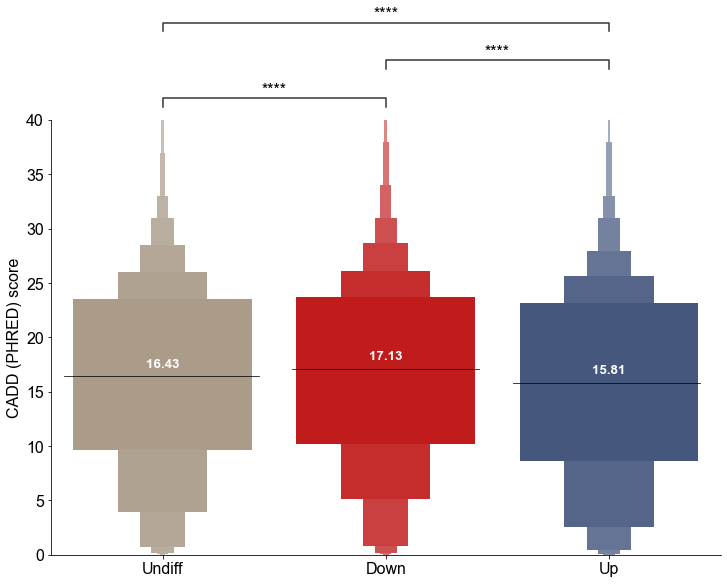

In [335]:
import seaborn as sns
from statannot import add_stat_annotation
import matplotlib.pyplot as plt

x, y = 'Check_diff', 'CADD_PHRED'

plt.rcParams.update({'font.size' : 16})

data = exotic_variants.copy()
data[x] = pd.Categorical(data[x], categories=['Undiff', 'Down', 'Up'], ordered=True)
data = data.sort_values(by='Check_diff')
print(data.Check_diff.unique())
# score_melt['Check_diff'] = score_melt['Check_diff'].astype(str)

hline = [
    [0.02,0.31],
    [0.36,0.64],
    [0.69,0.97],
]

i = 0
    
    
f, ax = plt.subplots(figsize=(12,8))
b = sns.boxenplot(data=data, x=x, y=y, linewidth=0, showfliers=False, palette={'Undiff' : '#B09C85', 'Up' : '#3C5488', 'Down' : '#DC0000'})

for j, bin in enumerate(data.Check_diff.unique()):
    m = score_melt.loc[(data[x] == bin), y].median()
    ax.axhline(xmin=hline[i][0], xmax=hline[i][1], y=m, color='black', lw=0.75)
    i+=1

medians = data[[x, y]].groupby([x])[y].median().reset_index().sort_values(by=x)[y]
vertical_offset = data[y].median() * 0.05 # offset from median for display

ax.set_xlabel('')
ax.set_ylabel('CADD (PHRED) score')
ax.spines['right'].set_linewidth(0)
ax.spines['top'].set_linewidth(0)

for j, xtick in enumerate(b.get_xticks()):
    if j <0:
        color='grey'
    else:
        color='w'
    b.text(xtick, medians[xtick] + vertical_offset,medians[xtick], 
            horizontalalignment='center',size='small',color=color,weight='semibold')

plt.ylim(0,40)
add_stat_annotation(ax, data=data, x='Check_diff', y='CADD_PHRED', order= ['Undiff', 'Up', 'Down'],
                            box_pairs=[('Undiff', 'Up'), ('Undiff', 'Down'), ('Up', 'Down')],
                            test='Mann-Whitney', text_format='star', loc='outside', verbose=2)

[Undiff, Down, Up]
Categories (3, object): [Undiff < Down < Up]
0 <class 'numpy.int64'>
1 <class 'numpy.int64'>
2 <class 'numpy.int64'>
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Undiff v.s. Up: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.107e-38 U_stat=1.022e+10
Up v.s. Down: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.304e-54 U_stat=4.782e+08
Undiff v.s. Down: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.161e-16 U_stat=1.037e+10


(<AxesSubplot:ylabel='MISTIC score'>,
  <statannot.StatResult.StatResult at 0x7f9fa944ec88>])

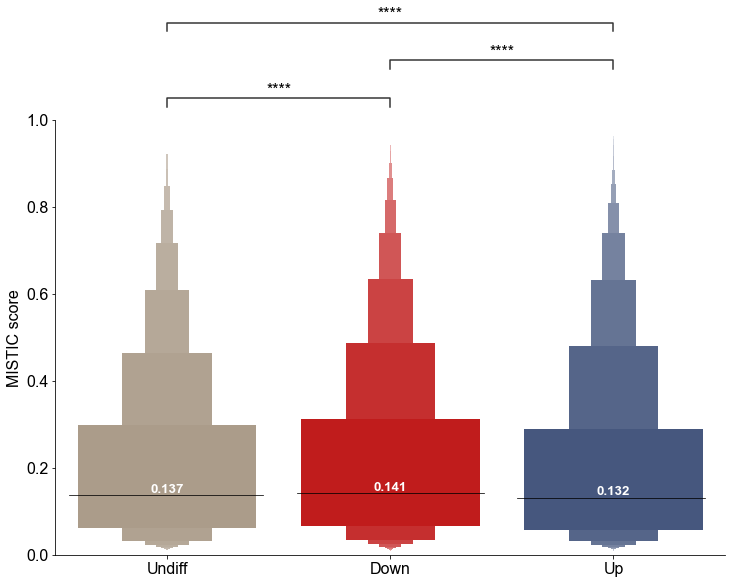

In [343]:
import seaborn as sns
from statannot import add_stat_annotation
import matplotlib.pyplot as plt

x, y = 'Check_diff', 'MISTIC'

plt.rcParams.update({'font.size' : 16})

data = exotic_variants.copy()
data[x] = pd.Categorical(data[x], categories=['Undiff', 'Down', 'Up'], ordered=True)
data = data.sort_values(by='Check_diff')
print(data.Check_diff.unique())
# score_melt['Check_diff'] = score_melt['Check_diff'].astype(str)

hline = [
    [0.02,0.31],
    [0.36,0.64],
    [0.69,0.97],
]

i = 0
    
    
f, ax = plt.subplots(figsize=(12,8))
b = sns.boxenplot(data=data, x=x, y=y, linewidth=0, showfliers=False, palette={'Undiff' : '#B09C85', 'Up' : '#3C5488', 'Down' : '#DC0000'})

for j, bin in enumerate(data.Check_diff.unique()):
    m = score_melt.loc[(data[x] == bin), y].median()
    ax.axhline(xmin=hline[i][0], xmax=hline[i][1], y=m, color='black', lw=0.75)
    i+=1

medians = data[[x, y]].groupby([x])[y].median().reset_index().sort_values(by=x)[y].round(3)
vertical_offset = data[y].median() * 0.05 # offset from median for display

ax.set_xlabel('')
ax.set_ylabel('MISTIC score')
ax.spines['right'].set_linewidth(0)
ax.spines['top'].set_linewidth(0)

for j, xtick in enumerate(b.get_xticks()):
    print(xtick, type(xtick))
    if j <0:
        color='grey'
    else:
        color='w'
    b.text(xtick, medians[xtick] + vertical_offset,medians[xtick], 
            horizontalalignment='center',size='small',color=color,weight='semibold')

plt.ylim(0,1)
add_stat_annotation(ax, data=data, x='Check_diff', y='CADD_PHRED', order= ['Undiff', 'Up', 'Down'],
                            box_pairs=[('Undiff', 'Up'), ('Undiff', 'Down'), ('Up', 'Down')],
                            test='Mann-Whitney', text_format='star', loc='outside', verbose=2)

[Undiff, Down, Up]
Categories (3, object): [Undiff < Down < Up]
0    0.000007
1    0.000007
2    0.000008
Name: AF, dtype: float64
0 <class 'numpy.int64'>
1 <class 'numpy.int64'>
2 <class 'numpy.int64'>
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Undiff v.s. Up: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.107e-38 U_stat=1.022e+10
Up v.s. Down: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.304e-54 U_stat=4.782e+08
Undiff v.s. Down: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.161e-16 U_stat=1.037e+10


(<AxesSubplot:ylabel='MAF'>,
  <statannot.StatResult.StatResult at 0x7f9fa971a7f0>])

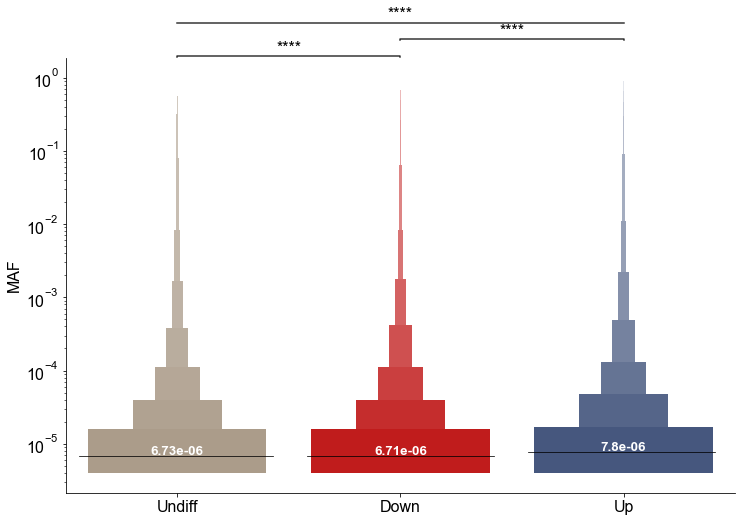

In [352]:
import seaborn as sns
from statannot import add_stat_annotation
import matplotlib.pyplot as plt

x, y = 'Check_diff', 'AF'

plt.rcParams.update({'font.size' : 16})

data = exotic_variants.copy()
data[x] = pd.Categorical(data[x], categories=['Undiff', 'Down', 'Up'], ordered=True)
data = data.sort_values(by='Check_diff')
print(data.Check_diff.unique())
# score_melt['Check_diff'] = score_melt['Check_diff'].astype(str)

hline = [
    [0.02,0.31],
    [0.36,0.64],
    [0.69,0.97],
]

i = 0
    
    
f, ax = plt.subplots(figsize=(12,8))
b = sns.boxenplot(data=data, x=x, y=y, linewidth=0, showfliers=False, palette={'Undiff' : '#B09C85', 'Up' : '#3C5488', 'Down' : '#DC0000'})

for j, bin in enumerate(data.Check_diff.unique()):
    m = score_melt.loc[(data[x] == bin), y].median()
    ax.axhline(xmin=hline[i][0], xmax=hline[i][1], y=m, color='black', lw=0.75)
    i+=1

medians = data[[x, y]].groupby([x])[y].median().reset_index().sort_values(by=x)[y].round(8)
vertical_offset = data[y].median() * 0.05 # offset from median for display

ax.set_xlabel('')
ax.set_ylabel('MAF')
ax.spines['right'].set_linewidth(0)
ax.spines['top'].set_linewidth(0)
print(medians)
for j, xtick in enumerate(b.get_xticks()):
    print(xtick, type(xtick))
    if j <0:
        color='grey'
    else:
        color='w'
    b.text(xtick, medians[xtick]+ vertical_offset,medians[xtick], horizontalalignment='center',size='small',color=color,weight='semibold')
plt.yscale('log')

add_stat_annotation(ax, data=data, x='Check_diff', y='CADD_PHRED', order= ['Undiff', 'Up', 'Down'],
                            box_pairs=[('Undiff', 'Up'), ('Undiff', 'Down'), ('Up', 'Down')],
                            test='Mann-Whitney', text_format='star', loc='outside', verbose=2)




In [243]:
bins = list(reversed([10**e for e in list(range(-1,-7,-1))]))
labels = ["{} - {}".format(bins[j], bins[j+1]) for j, e in enumerate(bins) if j < len(bins)-1]
labels

['1e-06 - 1e-05',
 '1e-05 - 0.0001',
 '0.0001 - 0.001',
 '0.001 - 0.01',
 '0.01 - 0.1']

In [295]:
af_lite = exotic_variants[['Check_diff', 'AF']]
af_lite['AF_bins'] = pd.cut(af_lite['AF'], bins=bins, labels=labels)
af_lite = af_lite.groupby('Check_diff')['AF_bins'].value_counts()
af_lite.name = 'AF_lite'
af_lite = af_lite.reset_index()
# af_lite = af_lite.loc[af_lite['Check_diff'] != 'Undiff']
af_lite = af_lite.pivot(index='AF_bins', columns='Check_diff', values='AF_lite').reset_index().sort_values(by='AF_bins')
af_lite['AF_bins'] = pd.Categorical(af_lite.AF_bins, categories=labels, ordered=True)
af_lite = af_lite.sort_values(by='AF_bins', ascending=False)
af_lite = af_lite[['AF_bins', 'Undiff', 'Down', 'Up']].set_index('AF_bins')
af_lite['Undiff_ratio'] = af_lite['Undiff'] / af_lite.Undiff.sum()
af_lite['Down_ratio'] = af_lite['Down'] / af_lite.Down.sum()
af_lite['Up_ratio'] = af_lite['Up'] / af_lite.Up.sum()
af_lite

/home/weber/.conda/envs/hail/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Check_diff,Undiff,Down,Up,Undiff_ratio,Down_ratio,Up_ratio
AF_bins,,,,,,
0.01 - 0.1,2358,134,141,0.003716,0.004015,0.004603
0.001 - 0.01,7887,430,449,0.012428,0.012883,0.014659
0.0001 - 0.001,29720,1562,1602,0.046831,0.046799,0.052303
1e-05 - 0.0001,181164,9510,9095,0.285470,0.284927,0.296941
1e-06 - 1e-05,413488,21741,19342,0.651555,0.651377,0.631493


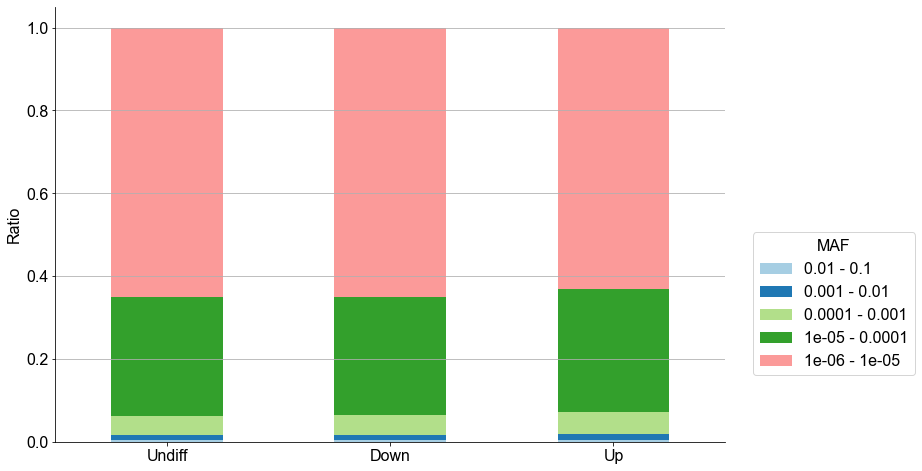

In [374]:
f, ax = plt.subplots(figsize=(12,8))
af_lite.filter(regex='ratio').T.plot.bar(stacked=True, ax=ax, legend=False, color=sns.color_palette('Paired'))
plt.legend(bbox_to_anchor=(1.03,0.5), title='MAF')
plt.grid(axis='y')
ax.set_xlabel('')
ax.set_ylabel('Ratio')
ax.set_xticklabels(['Undiff', 'Down', 'Up'], rotation=0)
ax.spines['right'].set_linewidth(0)
ax.spines['top'].set_linewidth(0)

In [218]:
csq = exotic_variants[['Check_diff', 'most_severe_consequence']].groupby('Check_diff')['most_severe_consequence'].value_counts()
csq.name = 'value'
csq = pd.DataFrame(csq).reset_index().pivot(index='most_severe_consequence', columns='Check_diff', values='value').fillna(0).astype(int)
csq.loc['Total'] = csq.sum(axis=0)
csq
csq.columns = ['Up', 'Undiff', 'Down']
csq = csq.reset_index().set_index('most_severe_consequence')

csq['Up_Ratio'] = 100 * (csq['Up'] / csq.loc['Total']['Up'])
csq['Undiff_Ratio'] = 100 * (csq['Undiff'] / csq.loc['Total']['Undiff'])

csq['Down_Ratio'] = 100 * (csq['Down'] / csq.loc['Total']['Down'])
csq = csq[['Undiff', 'Undiff_Ratio', 'Down', 'Down_Ratio', 'Up', 'Up_Ratio']]
csq.sort_values(by='Undiff_Ratio', ascending=False)
csq.to_excel('')

,Undiff,Undiff_Ratio,Down,Down_Ratio,Up,Up_Ratio
most_severe_consequence,,,,,,
Total,636933,100.000000,30746,100.000000,33486,100.000000
missense_variant,421231,66.134272,20684,67.273792,21870,65.310876
synonymous_variant,190272,29.873158,8908,28.972875,10213,30.499313
stop_gained,12602,1.978544,692,2.250699,640,1.911246
splice_region_variant,6429,1.009368,267,0.868406,349,1.042227
start_lost,2269,0.356238,91,0.295973,117,0.349400
stop_lost,987,0.154961,39,0.126846,45,0.134385
splice_donor_variant,580,0.091061,15,0.048787,20,0.059726
non_coding_transcript_exon_variant,580,0.091061,0,0.000000,91,0.271755


# Pathogenic

In [377]:
clinvar = pd.read_parquet(files['EXOTIC']['clinvar_file_path'])
clinvar = clinvar.loc[(clinvar['Status'] == 'Pathogenic') & (clinvar['Real_Status'].str.contains('onflict') == False)]
# clinvar = clinvar.loc[clinvar['OMIM_VARIANT_ID'] != ""]
# clinvar['ALT_Lite'] = clinvar['ALT'].apply(lambda r: eval(r)[0]) 
# clinvar['VAR_ID_Lite'] = clinvar['CHROM'].astype(str) + '_' + clinvar['POS'].astype(str) + '_' + clinvar['REF'].astype(str) + '_' + clinvar['ALT_Lite'].astype(str)

clinvar

,GENE,VAR_ID,CHROM,POS,REF,ALT,MC,Status,Real_Status,RS_STARS,CLNREVSTAT,HPO,rs,alleleid,OMIM_VARIANT_ID
79,SAMD11,1_879375_C_['T'],1,879375,C,['T'],nonsense,Pathogenic,Pathogenic,1,"criteria_provided,_single_submitter",[],None,929884,
105,KLHL17,1_899892_C_['A'],1,899892,C,['A'],missense_variant,Pathogenic,Likely_pathogenic,0,no_assertion_criteria_provided,[HP:0002575],None,904889,
125,ISG15,1_949523_C_['T'],1,949523,C,['T'],nonsense,Pathogenic,Pathogenic,0,no_assertion_criteria_provided,[],786201005,181485,147571.0003
138,ISG15,1_949696_C_['CG'],1,949696,C,['CG'],frameshift_variant,Pathogenic,Pathogenic,0,no_assertion_criteria_provided,[],672601345,171289,147571.0002
141,ISG15,1_949739_G_['T'],1,949739,G,['T'],nonsense,Pathogenic,Pathogenic,0,no_assertion_criteria_provided,[],672601312,171288,147571.0001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
770451,MT-CYB,MT_15637_C_['T'],MT,15637,C,['T'],synonymous_variant,Pathogenic,Likely_pathogenic,0,no_assertion_criteria_provided,[],527236190,153620,
770457,MT-CYB,MT_15649_A_['G'],MT,15649,A,['G'],synonymous_variant,Pathogenic,Likely_pathogenic,0,no_assertion_criteria_provided,[],527236191,153621,
770467,MT-CYB,MT_15670_T_['C'],MT,15670,T,['C'],synonymous_variant,Pathogenic,Likely_pathogenic,0,no_assertion_criteria_provided,[HP:0100615],193302997,153650,
770470,MT-CYB,MT_15682_A_['G'],MT,15682,A,['G'],synonymous_variant,Pathogenic,Likely_pathogenic,0,no_assertion_criteria_provided,[],527236192,153622,


In [378]:
exotic

,symbol,ensg,HGNC,Exon,mRNA_nb,mRNA_nb_total,MAP,mean_proportion,Adipose - Subcutaneous,Adipose - Visceral (Omentum),...,new_mRNA_nb_total,Ratio,CDS_start,CDS_stop,Share,Length,Ratio_num,Const_Alt,CDS_count,Check_diff
0,A2ML1,ENSG00000166535,23336,8975248-8975309,1,2,A2ML1_8975248-8975309,0.69514,0.156704,0.156704,...,2,1/2,8975248,8975309,False,61,0.500000,Alt,36,Undiff
1,A2ML1,ENSG00000166535,23336,8975778-8975961,1,2,A2ML1_8975778-8975961,0.69514,0.156704,0.156704,...,2,1/2,8975778,8975961,False,183,0.500000,Alt,36,Undiff
2,A2ML1,ENSG00000166535,23336,8976316-8976478,1,2,A2ML1_8976316-8976478,0.69514,0.156704,0.156704,...,2,1/2,8976316,8976478,False,162,0.500000,Alt,36,Undiff
3,A2ML1,ENSG00000166535,23336,8982323-8982375,1,2,A2ML1_8982323-8982375,0.69514,0.156704,0.156704,...,2,1/2,8982323,8982375,False,52,0.500000,Alt,36,Undiff
4,A2ML1,ENSG00000166535,23336,8987258-8987278,1,2,A2ML1_8987258-8987278,0.69514,0.156704,0.156704,...,2,1/2,8987258,8987278,False,20,0.500000,Alt,36,Undiff
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29295,ZXDC,ENSG00000070476,28160,126158475-126158570,1,2,ZXDC_126158475-126158570,0.20989,0.000470,0.009736,...,2,1/2,126158475,126158570,False,95,0.500000,Alt,11,Undiff
29296,ZXDC,ENSG00000070476,28160,126160608-126160789,1,2,ZXDC_126160608-126160789,0.20989,0.000470,0.009736,...,2,1/2,126160608,126160789,False,181,0.500000,Alt,11,Undiff
29297,ZXDC,ENSG00000070476,28160,126178496-126178580,1,2,ZXDC_126178496-126178580,0.20989,0.000470,0.009736,...,2,1/2,126178496,126178580,False,84,0.500000,Alt,11,Undiff
29298,ZXDC,ENSG00000070476,28160,126180378-126181063,1,2,ZXDC_126180378-126181063,0.34803,0.030669,0.014999,...,2,1/2,126180378,126181063,False,685,0.500000,Alt,11,Undiff


In [382]:
def mp_variants(gene, exotic, clinvar, l):
    exotic_tmp_gene = exotic.loc[exotic['symbol'] == gene]
    clinvar_tmp_gene = clinvar.loc[clinvar['GENE'] == gene]
    for exon in exotic_tmp_gene.Exon.unique().tolist():
        match_variants = clinvar_tmp_gene.POS.between(int(exon.split('-')[0]), int(exon.split('-')[1]))
        match_variants = clinvar_tmp_gene.loc[match_variants.loc[match_variants == True].index.tolist(), 'alleleid'].values.tolist()
        if match_variants:
            l.append({exon : match_variants})
        
# for gene in tqdm():
m = multiprocessing.Manager()
l = m.list()
genes = exotic.symbol.unique().tolist()
parmap.starmap(mp_variants, list(zip(genes)), exotic, clinvar, l, pm_pbar=True)
map_d = {k: v for d in l for k, v in d.items()}
exotic['AlleleIDs_clinvar'] = exotic['Exon'].map(map_d)
# exotic_up['AlleleIDs_clinvar'] = exotic_up['Exon'].map(map_d)
# exotic_down['AlleleIDs_clinvar'] = exotic_down['Exon'].map(map_d)


# print(l)

6448it [09:35, 11.20it/s]                          


In [387]:
exotic.loc[exotic['Check_diff'] != 'Undiff'].dropna(subset=['AlleleIDs_clinvar'])['symbol'].nunique()

105